# Introduction
In this notebook, we will load serialized `ContactSequence` files from the "examples" directory. See the Readme file of this directory for more information about this files: https://github.com/loco-3d/multicontact-api/tree/master/examples

First we will plot various data stored in the file like CoM trajectory or contact placement, then we will visualize the wholebody motion.

## Displaying the CoM trajectory

The first step is to load the ContactSequence from a file. Feel free to change the name of the file loaded to any of the files in the example folder, but do not use the files without any suffix as they do not store any centroidal data. 

In [1]:
from multicontact_api import ContactSequence

cs = ContactSequence()
cs.loadFromBinary("../examples/walk_20cm_REF.cs")

print("Number of contact phases: ", cs.size())
print("Duration of the motion: ", cs.contactPhases[-1].timeFinal)

Number of contact phases:  23
Duration of the motion:  35.00000000000026


Now we are going to plot the CoM position and it's derivatives for the complete motion. As seen in the previous notebook, each contact phases of the sequence store the trajectoires for this specific time interval, in order to plot the traejctories for the complete motion we should iterate over all the phases. 

Fortunately, there is several helper methods that you can use to concatenate the trajectories of all the phases in a single `NDCurves` object which can be manipulated easily. 

In [2]:
c_t = cs.concatenateCtrajectories()
dc_t = cs.concatenateDCtrajectories()
ddc_t = cs.concatenateDDCtrajectories()

Then, let's create an helper method to discretize any NDCurves object at the desired frequency:

In [3]:
def discretize_curve(curve, dt):
    """
    Discretize the given curve at the given dt
    return the result as an array (one column per discret point)
    In case where the time interval of the curve is not a multiple of dt, the last point is still included
    This mean that the timestep between the two last points may be less than dt
    :param curve: a curve object, require operator (), min() and max()
    :param dt: the discretization step
    :return: an array of shape (curve.dim(), numPoints) and an array corresponding to the timeline
    """
    numPoints = round((curve.max() - curve.min()) / dt) + 1
    res = np.zeros([curve.dim(), numPoints])
    timeline = np.zeros(numPoints)
    t = curve.min()
    for i in range(numPoints):
        res[:, i] = curve(t)
        timeline[i] = t
        t += dt
        if t > curve.max():
            t = curve.max()
    return res, timeline

The first simple plot will display the x-y position of the CoM:

<IPython.core.display.Javascript object>


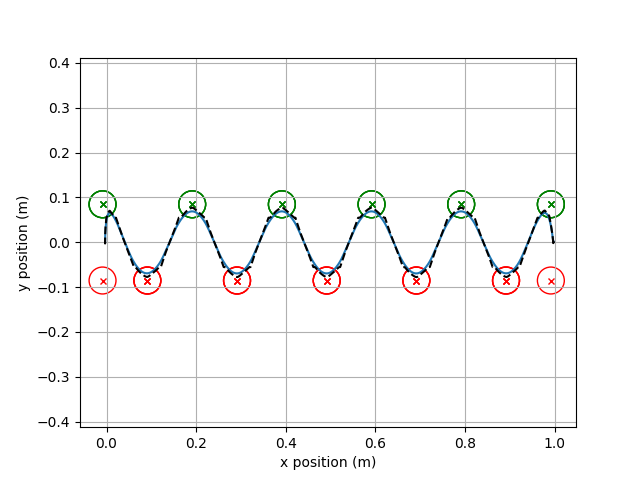

In [4]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

# Discretize the curve
DT = 0.01
c_k = discretize_curve(c_t, DT)[0]

# Create a new plot
fig = plt.figure("CoM position(xy)")
plt.xlabel("x position (m)")
plt.ylabel("y position (m)")
plt.axis("equal")
plt.grid(True)
plt.plot(
    c_k[0, :], c_k[1, :]
)  # plot the CoM position along x in function of the y position

The previous plot coul be improved by adding the contact positions. Lets display all the contacts as small circles. 

In [6]:
colors = ["g", "r"]  # define the colors used for the circles
circle_radius = 0.03
effector_list = cs.getAllEffectorsInContact()
ax = fig.gca()

# Iterate for all phases
for p in cs.contactPhases:
    for ee_name in p.effectorsInContact():
        # plot x for the center of the feets contact,
        # and a circle of 3cm of radius around it :
        pos = p.contactPatch(ee_name).placement.translation
        color = colors[effector_list.index(ee_name)]
        plt.plot(pos[0], pos[1], marker="x", markersize=5, color=color)
        circle_r = plt.Circle((pos[0], pos[1]), circle_radius, color=color, fill=False)
        ax.add_artist(circle_r)

One last addition to this plot could be to add the ZMP trajectory (as a black-dashed line):

In [7]:
zmp_t = cs.concatenateZMPtrajectories()
zmp_k = discretize_curve(zmp_t, DT)[0]
plt.plot(zmp_k[0, :], zmp_k[1, :], color="k", linestyle="dashed")

For a second plot, we are going to display the CoM position and it's two derivatives in a 3*3 plot. The lines are the position, velocity and acceleration and the column the x, y, z axis.


<IPython.core.display.Javascript object>


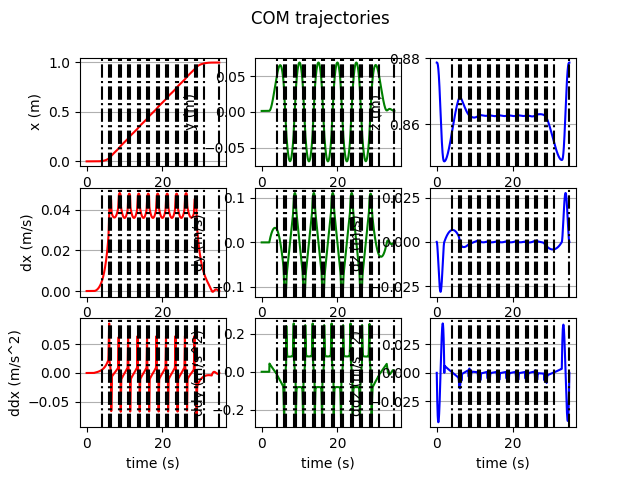

In [8]:
labels = [
    "x (m)",
    "y (m)",
    "z (m)",
    "dx (m/s)",
    "dy (m/s)",
    "dz (m/s)",
    "ddx (m/s^2)",
    "ddy (m/s^2)",
    "ddz (m/s^2)",
]
colors = ["r", "g", "b"]

# create a figure with 3*3 subplots
fig, ax = plt.subplots(3, 3)
fig.suptitle("COM trajectories")

# discretize the CoM trajectories and it's derivatives:
c_k, timeline = discretize_curve(c_t, DT)
dc_k = discretize_curve(dc_t, DT)[0]
ddc_k = discretize_curve(ddc_t, DT)[0]

# stack the values for easier access in the loops:
values = np.vstack([c_k, dc_k, ddc_k])

for i in range(3):  # line = pos,vel,acc
    for j in range(3):  # col = x,y,z
        ax_sub = ax[i, j]
        ax_sub.plot(timeline.T, values[i * 3 + j, :].T, color=colors[j])
        ax_sub.set_xlabel("time (s)")
        ax_sub.set_ylabel(labels[i * 3 + j])
        ax_sub.yaxis.grid()

Finally, we can add to the previous plot small vertical line showing the contact changes timings. 

In [9]:
for i in range(3):  # line = pos,vel,acc
    for j in range(3):  # col = x,y,z
        ax_sub = ax[i, j]
        # Add vertical line at each contact change time
        for phase in cs.contactPhases:
            ax_sub.axvline(phase.timeFinal, linestyle="-.", color="k")

## Displaying a joint trajectory

For this section you will need two additionnal depencies: the simplifed Talos model and the Meshcat 3D visualizer:

* install the binary package `robotpkg-py3\*-example-robot-data` (see http://robotpkg.openrobots.org/robotpkg-wip.html if you haven't configured robotpkg on your system yet
* `pip3 install --user meshcat`

First, let's load the contact sequence from the file. Feel free to change the name of the file loaded to any of the files in the example folder, but be sure to use the `_WB` suffix: the other files do not store joint trajectories.

In [10]:
from multicontact_api import ContactSequence

cs = ContactSequence()
cs.loadFromBinary("../examples/walk_20cm_WB.cs")

print("Number of contact phases: ", cs.size())
print("Duration of the motion: ", cs.contactPhases[-1].timeFinal)

Number of contact phases:  23
Duration of the motion:  35.00000000000026


Then let's load the robot model in Pinocchio and initialize the viewer:

In [11]:
from example_robot_data import load
from pinocchio.visualize import MeshcatVisualizer

robot = load("talos")
viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(loadModel=True)
viz.viewer.jupyter_cell()

q0 = robot.q0
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


After the initialization you should get a link to open meshcat in your browser, and you should see Talos standing in it's reference configuration. 

Now we are simply going to retrieve the complete joint trajectory from the file (see the previous section), discretize it and send the configurations to the viewer.

In [ ]:
import time

# concatenate the joint trajectories of each phases in a single curve object
q_t = cs.concatenateQtrajectories()
DT = 0.04  # 25 FPS

t = 0.0
t_end = q_t.max()

while t <= t_end:
    t_start = time.time()
    viz.display(q_t(t))  # Display the current configuration
    elapsed = (
        time.time() - t_start
    )  # Save the time required to display one configuration
    if elapsed > DT:
        print(
            "Warning : display not real time ! choose a greater time step for the display."
        )
    else:
        time.sleep(DT - elapsed)
    t += DT